In [2]:
import pickle
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
from scipy.stats import kendalltau

os.chdir('/data/yosef2/users/chenling/HarmonizationSCANVI')
save_path = "../symsim_scVI/symsim_result/DE/"


In [3]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [4]:
nevf = pd.read_csv(os.path.join(save_path, "n_evf.csv"),
                             sep=",", index_col=0, header=0)
nevf=np.asarray(nevf['x'])

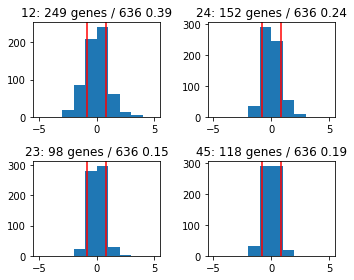

In [5]:
theoretical_FC = pd.read_csv(os.path.join(save_path, "theoreticalFC.csv"),
                             sep=",", index_col=0, header=0)

plt.figure(figsize=(5,4))
for i,key in enumerate(['12','24','23','45']):
    plt.subplot(2,2,i+1)
    log_FC = theoretical_FC[key][nevf==3]
    plt.hist(log_FC,range=(-5,5))
    detected_genes = np.sum(np.abs(log_FC) >= 0.8)
    plt.title("%s: %i genes / %i %.2f"%(key,detected_genes,log_FC.shape[0],detected_genes/log_FC.shape[0]))
#     plt.title(key)
    plt.axvline(x=-0.8,color='red')
    plt.axvline(x=0.8,color='red')
    plt.tight_layout()

plt.savefig(save_path+'DE_simulation.0.logFC.pdf')


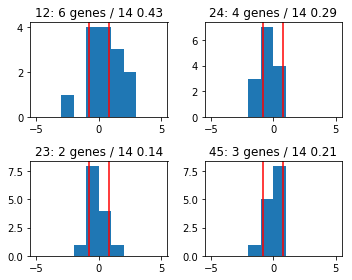

In [40]:
theoretical_FC = pd.read_csv(os.path.join(save_path, "theoreticalFC.csv"),
                             sep=",", index_col=0, header=0)

plt.figure(figsize=(5,4))
for i,key in enumerate(['12','24','23','45']):
    plt.subplot(2,2,i+1)
    log_FC = theoretical_FC[key][nevf==5]
    plt.hist(log_FC,range=(-5,5))
    detected_genes = np.sum(np.abs(log_FC) >= 0.8)
    plt.title("%s: %i genes / %i %.2f"%(key,detected_genes,log_FC.shape[0],detected_genes/log_FC.shape[0]))
#     plt.title(key)
    plt.axvline(x=-0.8,color='red')
    plt.axvline(x=0.8,color='red')
    plt.tight_layout()

plt.savefig(save_path+'DE_simulation.5.logFC.pdf')

In [6]:
def eval_de(log_fold_change, logFC):
    """
    :param log_fold_change: groundtruth
    :param bayes_f: non-log Bayes Factor
    :return:
    """
    auc_1 = roc_auc_score(np.abs(log_fold_change) >= 0.6, np.abs(logFC))
    auc_2 = roc_auc_score(np.abs(log_fold_change) >= 0.8, np.abs(logFC))
    spear = spearmanr(logFC, log_fold_change)
    kend = kendalltau(logFC, log_fold_change)
    return auc_1, auc_2, spear[0], kend[0]


In [36]:
scvires={'bayes_A':{},'bayes_B':{},'bayes_AB':{},'bayes_scanviAB':{}}

for type in ['bayes_A','bayes_B','bayes_AB','bayes_scanviAB']:
    scvires[type] = {'12':{},'23':{},'24':{},'45':{}}
    for comparison in ['12','23','24','45']:
        scvires[type][comparison] = {'R1':[],'R2':[],'S':[],'K':[]}
        for rep in range(9):
            X = pd.read_csv(os.path.join(save_path,'SIM.result.%s.%i.mis0.00.csv'%(comparison,rep+1)))
            X = X[type]
            X = np.log(X + 1e-8) - np.log(1 - X + 1e-8)
            stats = eval_de(theoretical_FC[comparison], X)
            for i,x in enumerate(['R1','R2','S','K']):
                scvires[type][comparison][x].append(stats[i])


In [49]:
edgeR_res = {'12':{},'23':{},'24':{},'45':{}}
for comparison in ['12','23','24','45']:
    edgeR_res[comparison] = {'A': {}, 'B': {}, 'AB': {}}
    for batch in ['A', 'B', 'AB']:
        edgeR_res[comparison][batch] = {'R1':[],'R2':[],'S':[],'K':[]}
        for rep in range(9):
            X = pd.read_csv(os.path.join(save_path, 'EdgeR/%s.%i.0.00.%s.edgeR.csv') % (batch, (rep+1), comparison))
            stats = eval_de(theoretical_FC[comparison], -X['logFC'])
            for i,x in enumerate(['R1','R2','S','K']):
                edgeR_res[comparison][batch][x].append(stats[i])


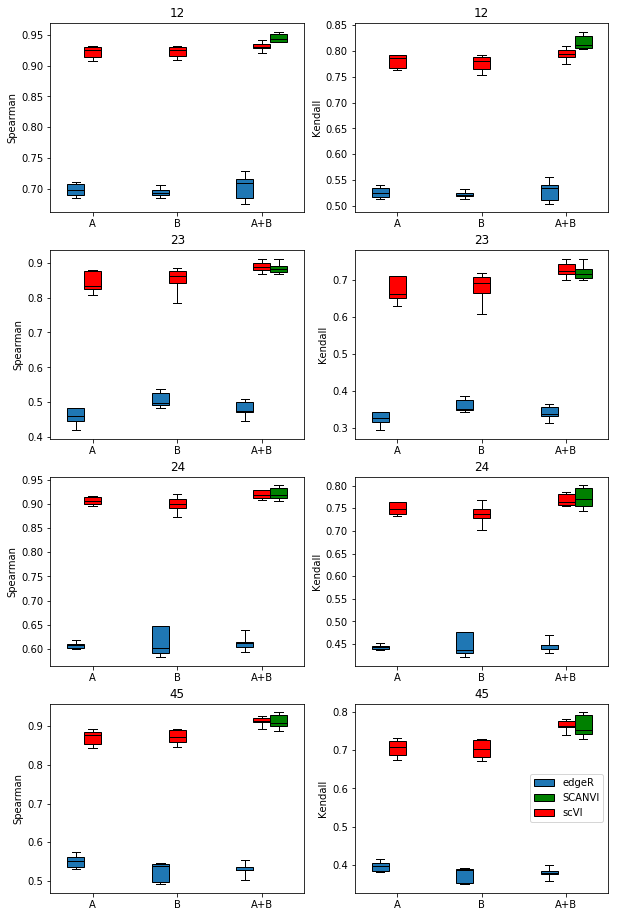

In [50]:
measure_names = ['Spearman','Kendall']
plt.figure(figsize=(10, 16))
for name, measure in enumerate(['S', 'K']): 
    for row,comparison in enumerate(['12','23','24','45']):
        props = dict(widths=0.2, patch_artist=True, medianprops=dict(color="black"), whis=[5, 95], sym="")

        #AUC CD$CD*
        ax = plt.subplot(4, 2, row*2+name+1)
        ax.set_ylabel(measure_names[name])
#         ax.set_ylabel(comparison)
        plt.title(comparison)
        bp1 = ax.boxplot([np.abs(edgeR_res[comparison][x][measure]) for x in ['A','B','AB'] ], positions=[0, 1, 2], **props)
        bp2 = ax.boxplot([scvires['bayes_scanviAB'][comparison][measure]], positions=[2.4], **props)
        bp3 = ax.boxplot([scvires[x][comparison][measure] for x in ['bayes_A','bayes_B','bayes_AB']], positions=[0.2, 1.2, 2.2], **props)

        for patch in bp3['boxes']:
            patch.set_facecolor('red')
        for patch in bp2['boxes']:
            patch.set_facecolor('green')

        ax.set_xticklabels(['A','B', 'A+B'])

ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['edgeR', 'SCANVI', 'scVI'])
plt.savefig('DEsim.pdf')

In [ ]:
np.unique(scvi_pred[2000:4000],return_counts=True)

In [ ]:
# compute average classification accuracy 
truelab = np.genfromtxt(save_path + 'DE.obsv.labels.csv',)
batch = np.genfromtxt(save_path + 'DE.obsv.batch.csv',)
scvi = []
scanvi=[]
for i in range(50):
    pred = pd.read_csv(save_path + 'pred_labels.%i.csv'%(i+1))
    scvi_pred = np.asarray(pred['scVI'])
    scvi.append([np.mean(scvi_pred==truelab),
        np.mean(scvi_pred[batch==0]==truelab[batch==0]),
        np.mean(scvi_pred[batch==1]==truelab[batch==1])])
    scanvi_pred = np.asarray(pred['scANVI'])
    scanvi.append([np.mean(scanvi_pred==truelab),
        np.mean(scanvi_pred[batch==0]==truelab[batch==0]),
        np.mean(scanvi_pred[batch==1]==truelab[batch==1])])



In [ ]:
mean = np.asarray(scvi).mean(axis=0)
std = np.asarray(scvi).std(axis=0)
for i in range(3):
    print('average accuracy = %.3f±%.3f' % (mean[i],std[i]))

In [ ]:
mean = np.asarray(scanvi).mean(axis=0)
std = np.asarray(scanvi).std(axis=0)
for i in range(3):
    print('average accuracy = %.3f±%.3f' % (mean[i],std[i]))

In [ ]:
# compute average classification accuracy 
truelab = np.genfromtxt(save_path + 'DE.obsv.labels.csv',)
batch = np.genfromtxt(save_path + 'DE.obsv.batch.csv',)
scvi = []
scanvi=[]
for i in range(36):
    pred = pd.read_csv(save_path + 'pred_labels.%i.mis0.01.csv'%(i+1))
    scvi_pred = np.asarray(pred['scVI'])
    scvi.append([np.mean(scvi_pred==truelab),
        np.mean(scvi_pred[batch==0]==truelab[batch==0]),
        np.mean(scvi_pred[batch==1]==truelab[batch==1])])
    scanvi_pred = np.asarray(pred['scANVI'])
    scanvi.append([np.mean(scanvi_pred==truelab),
        np.mean(scanvi_pred[batch==0]==truelab[batch==0]),
        np.mean(scanvi_pred[batch==1]==truelab[batch==1])])



In [ ]:
mean = np.asarray(scvi).mean(axis=0)
std = np.asarray(scvi).std(axis=0)
for i in range(3):
    print('average accuracy = %.3f±%.3f' % (mean[i],std[i]))

In [ ]:
mean = np.asarray(scanvi).mean(axis=0)
std = np.asarray(scanvi).std(axis=0)
for i in range(3):
    print('average accuracy = %.3f±%.3f' % (mean[i],std[i]))